In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [4]:
dic_data_raw = {}
dic_data_processed = {}

# Aizarani et al. Liver atlas
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_processed['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

DNAME_LIST = ['aizarani']

### Load score 

In [6]:
SCORE_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.liver_atlas.gwas_max_abs_z.top500'
df_score = None
trait_list = []
for file in [x for x in os.listdir(SCORE_PATH) if '.score.gz' in x]:
    trait = file.replace('.score.gz','')
    trait_list.append(trait)
    temp_df = pd.read_csv(join(SCORE_PATH,file), sep='\t', index_col=0)
    temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
    temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]

    if df_score is None:
        df_score = temp_df.copy()
    else:
        df_score = pd.concat([df_score, temp_df], axis=1)

In [7]:
cell_list = list(df_score.index)
dic_data_raw['aizarani'] = dic_data_raw['aizarani'][cell_list, :].copy()
dic_data_processed['aizarani'] = dic_data_processed['aizarani'][cell_list, :].copy()

### Analysis 

In [8]:
dic_data_processed['aizarani'].obs['cluster_id'] = ['c%d'%x for x in dic_data_processed['aizarani'].obs['cluster_id']]

... storing 'cluster_id' as categorical


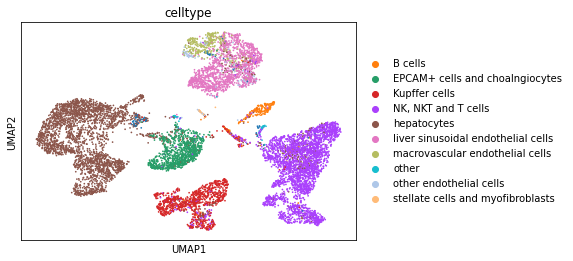

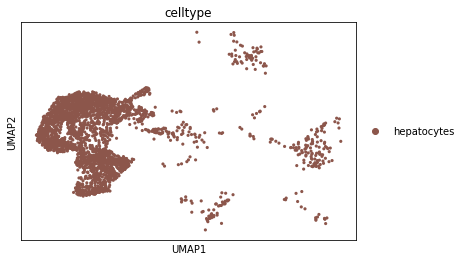

Trying to set attribute `.uns` of view, copying.


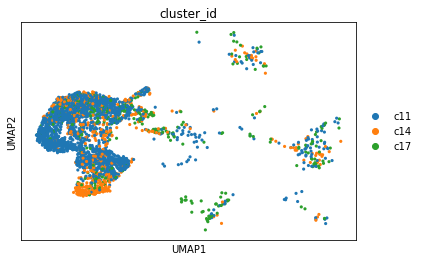

UKB_460K.blood_LYMPHOCYTE_COUNT 420
UKB_460K.biochemistry_TotalBilirubin 396
UKB_460K.biochemistry_DirectBilirubin 384
UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 282
UKB_460K.biochemistry_AlanineAminotransferase 806
UKB_460K.biochemistry_Testosterone_Male 500
UKB_460K.disease_HI_CHOL_SELF_REP 103
PASS_Multiple_sclerosis 131
UKB_460K.disease_THYROID_ANY_SELF_REP 417
UKB_460K.biochemistry_ApolipoproteinA 974
UKB_460K.biochemistry_ApolipoproteinB 523
UKB_460K.biochemistry_LDLdirect 700
UKB_460K.biochemistry_Cholesterol 524
UKB_460K.biochemistry_SHBG 939
PASS_HDL 268
UKB_460K.biochemistry_AlkalinePhosphatase 957
UKB_460K.biochemistry_VitaminD 973
PASS_LDL 492
UKB_460K.biochemistry_Triglycerides 1321
UKB_460K.biochemistry_HDLcholesterol 714
UKB_460K.disease_AID_ALL 680
PASS_Triglycerides 447


In [9]:
sc.pl.umap(dic_data_processed['aizarani'], color='celltype')
sc.pl.umap(dic_data_processed['aizarani'][dic_data_processed['aizarani'].obs['celltype']=='hepatocytes'],
           color='celltype')
sc.pl.umap(dic_data_processed['aizarani'][dic_data_processed['aizarani'].obs['celltype']=='hepatocytes'],
           color='cluster_id')
cell_list = list(dic_data_processed['aizarani'].obs.index)

# Interesting traits 
trait_plot_list = []
for trait in trait_list:
    v_fdr = df_score['%s.fdr'%trait].values
    if (v_fdr<0.05).sum()>100:
        print(trait, (v_fdr<0.05).sum())
        trait_plot_list.append(trait)

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


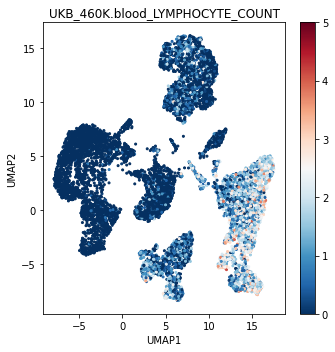

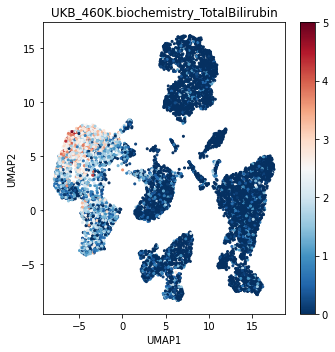

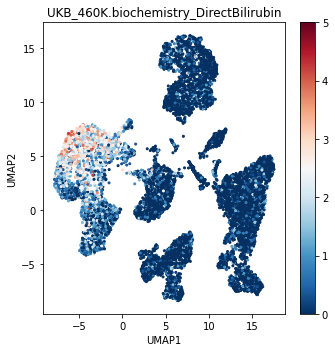

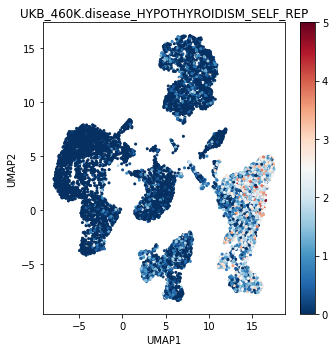

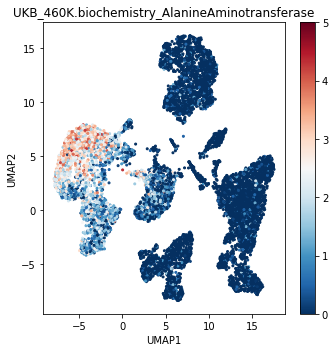

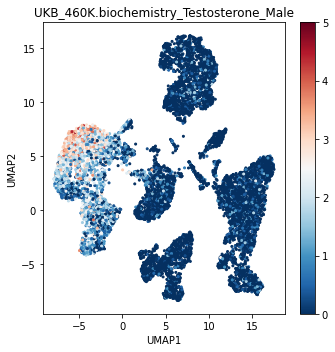

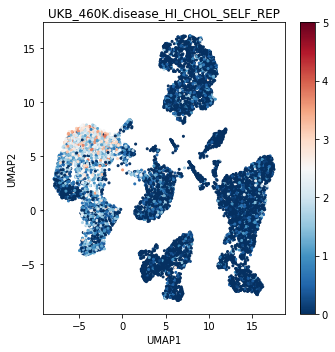

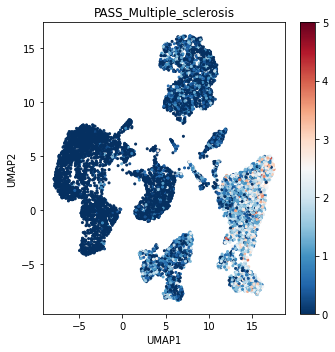

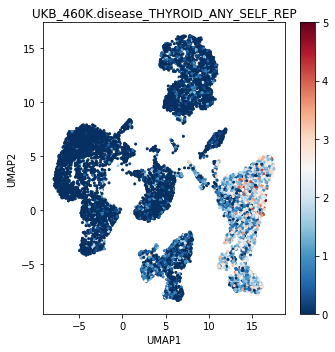

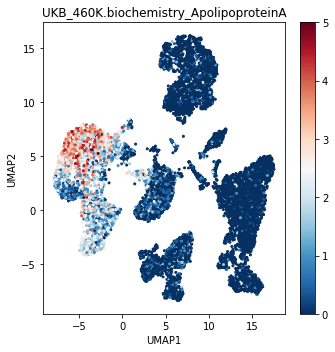

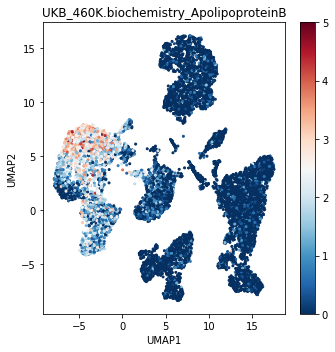

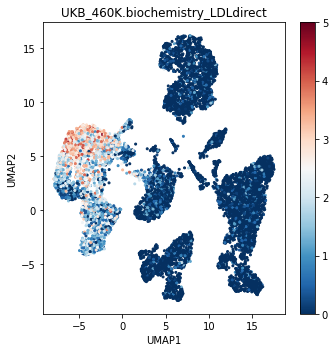

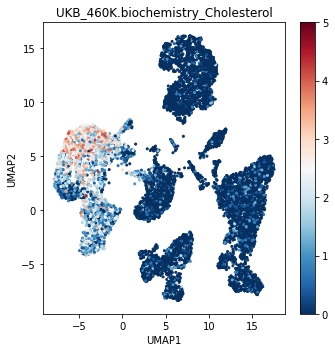

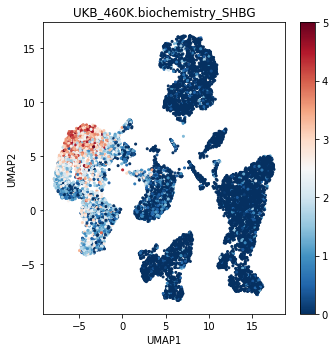

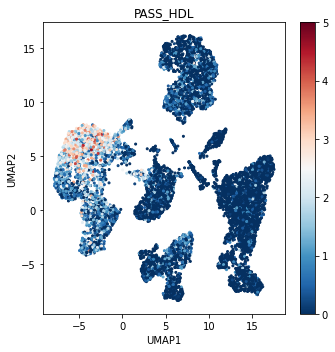

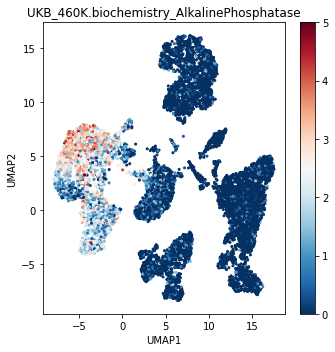

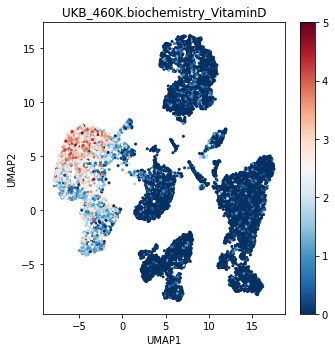

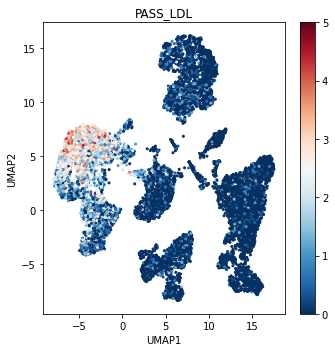

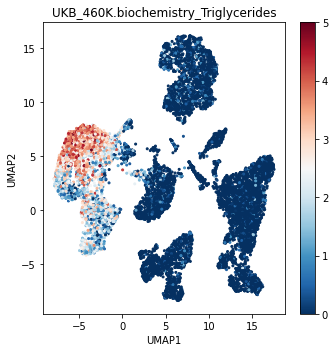

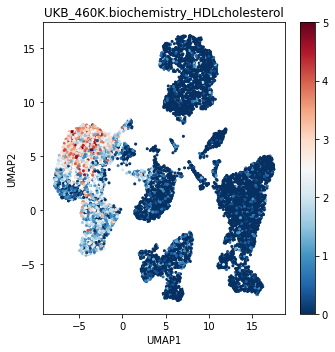

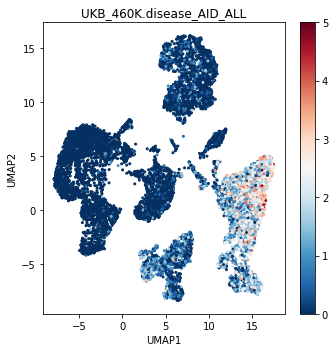

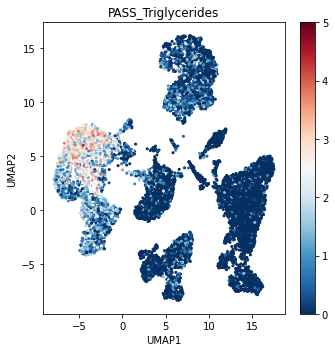

In [10]:
for trait in trait_plot_list:
    df_plot = pd.DataFrame(index=cell_list,d
                           data={'UMAP1':dic_data_processed['aizarani'].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_processed['aizarani'].obsm['X_umap'][:,1],
                                 'zsc':df_score.loc[cell_list, '%s.zscore'%trait].values})
    
    plt.figure(figsize=[5,5])
    max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
    min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['zsc'],
                cmap='RdBu_r', vmax=5, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%trait)
    plt.tight_layout()

In [11]:
gene_list = ['GLUL', 'APOE', 'CYP1A2', 'CYP2E1', 'ALB', 'PCK1']
for gene in gene_list: 
    if gene not in dic_data_raw['aizarani'].var_names:
        print(gene)

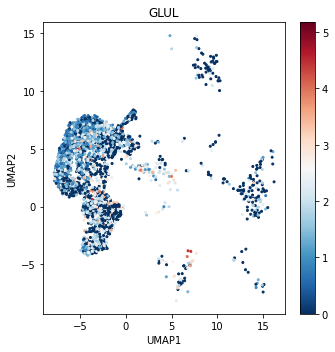

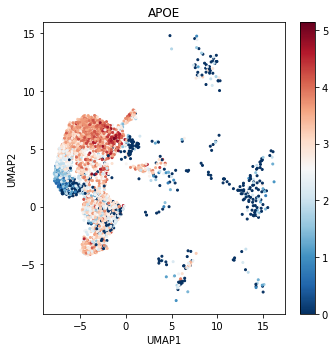

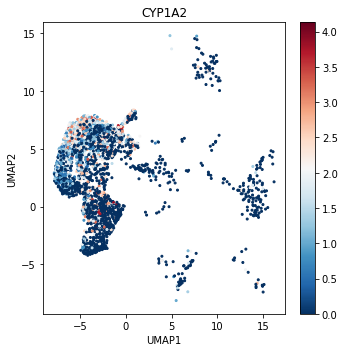

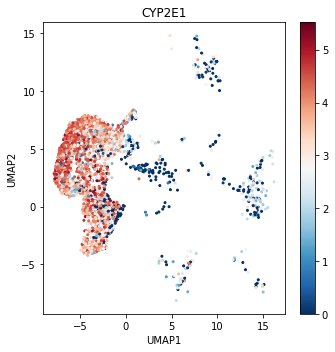

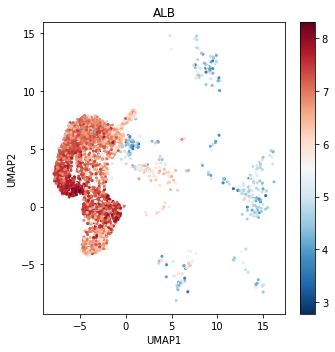

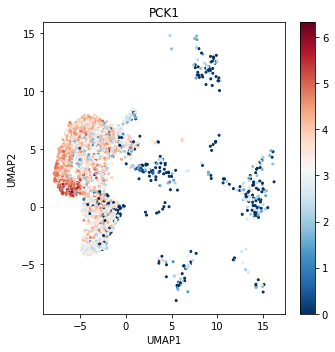

In [12]:
adata_small = dic_data_raw['aizarani'][dic_data_raw['aizarani'].obs['celltype']=='hepatocytes'].copy()
cell_list = list(adata_small.obs.index)

df_plot = pd.DataFrame(index=cell_list,
                       data={x:adata_small[:,x].X.toarray().reshape([-1]) for x in gene_list})
df_umap = pd.DataFrame(index=dic_data_processed['aizarani'].obs_names,
                       data={'UMAP1':dic_data_processed['aizarani'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_processed['aizarani'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(df_umap)

for gene in gene_list:
    
    plt.figure(figsize=[5,5])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='RdBu_r', s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%gene)
    plt.tight_layout()
    plt.show()

In [24]:
df_zonation = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
                          'Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t', index_col=0)

In [25]:
df_zonation

,Module,P301_8_130,P301_8_127,P301_5_28,P301_4_98,P301_17_5,P301_10_123,P301_4_103,P301_8_131,P301_8_154,...,P301_6_175,P301_6_147,P301_18_146,P301_6_141,P301_6_153,P301_6_123,P301_6_181,P301_12_161,P301_6_178,P301_18_176
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
ACADM,1,-1.892985,-1.889814,-1.886645,-1.883479,-1.880315,-1.877153,-1.873993,-1.870836,-1.867681,...,-0.084579,-0.094507,-0.104455,-0.114421,-0.124406,-0.134410,-0.144433,-0.154474,-0.164533,-0.174611
AFM,1,-2.374369,-2.373595,-2.372819,-2.372039,-2.371257,-2.370472,-2.369684,-2.368893,-2.368099,...,0.565645,0.562683,0.559714,0.556738,0.553756,0.550767,0.547772,0.544771,0.541763,0.538749
AGL,1,-1.811760,-1.811965,-1.812166,-1.812363,-1.812555,-1.812744,-1.812929,-1.813109,-1.813285,...,2.140241,2.145407,2.150576,2.155749,2.160924,2.166102,2.171283,2.176467,2.181653,2.186842
ANTXR2,1,-1.799543,-1.797541,-1.795538,-1.793535,-1.791532,-1.789528,-1.787524,-1.785520,-1.783516,...,0.547106,0.546021,0.544938,0.543857,0.542777,0.541699,0.540624,0.539550,0.538479,0.537409
APLP2,1,-3.630012,-3.621315,-3.612630,-3.603959,-3.595299,-3.586652,-3.578018,-3.569395,-3.560785,...,0.962515,0.966911,0.971313,0.975720,0.980132,0.984550,0.988973,0.993401,0.997835,1.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPS19,35,1.950090,1.949356,1.948621,1.947886,1.947152,1.946417,1.945681,1.944946,1.944209,...,-2.185280,-2.188392,-2.191506,-2.194622,-2.197741,-2.200862,-2.203984,-2.207109,-2.210237,-2.213366
RPS9,35,1.899189,1.896911,1.894635,1.892362,1.890091,1.887822,1.885555,1.883291,1.881028,...,-2.033410,-2.034628,-2.035842,-2.037053,-2.038260,-2.039464,-2.040665,-2.041862,-2.043056,-2.044246
SEC14L2,35,2.087039,2.084403,2.081768,2.079134,2.076500,2.073868,2.071236,2.068605,2.065975,...,-1.725249,-1.725800,-1.726347,-1.726892,-1.727434,-1.727972,-1.728507,-1.729040,-1.729569,-1.730095


In [29]:
(adata.obs['celltype']=='hepatocytes').sum()

3040

In [26]:
# Diffusion map 
adata = dic_data_raw['aizarani'].copy()
# adata = dic_data_raw['aizarani'][dic_data_processed['aizarani'].obsm['X_umap'][:,0]<0,:].copy()
# adata = adata[adata.obs['celltype']=='hepatocytes'].copy()
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=100)
# sc.tl.umap(adata)
# adata = adata[dic_data_processed['aizarani'].obsm['X_umap'][:,0]<0,:].copy()
# adata = adata[adata.obs['celltype']=='hepatocytes'].copy()
sc.tl.diffmap(adata)

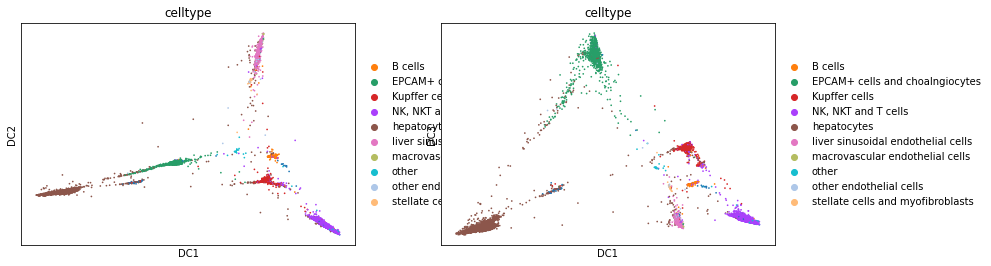

In [28]:
sc.pl.diffmap(adata, color='celltype', components=['1,2', '1,3'])

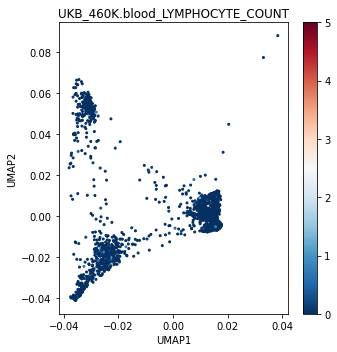

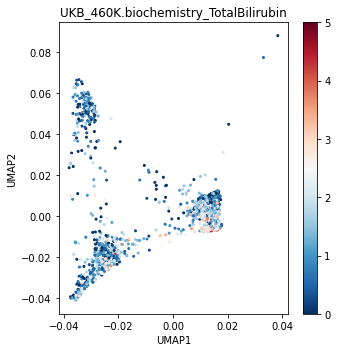

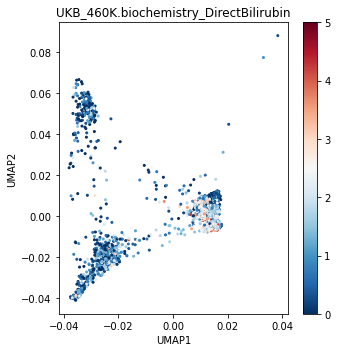

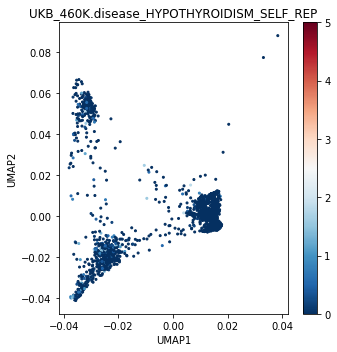

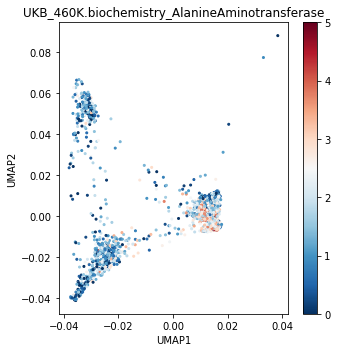

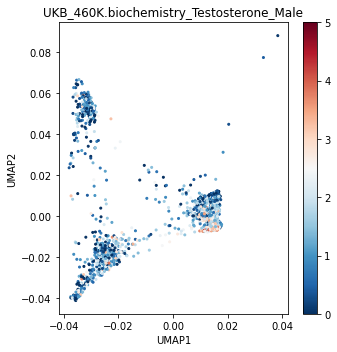

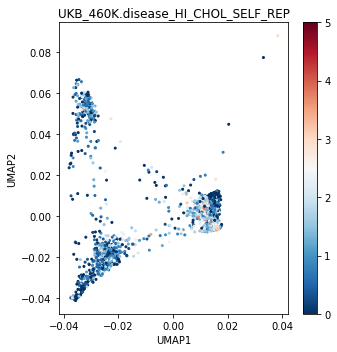

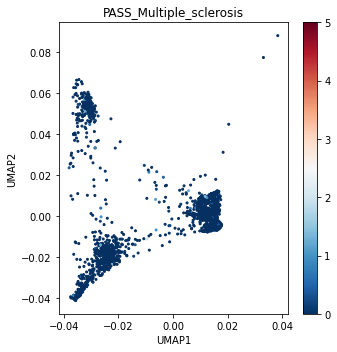

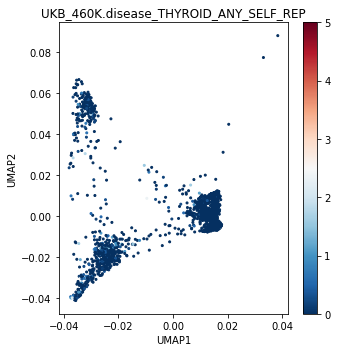

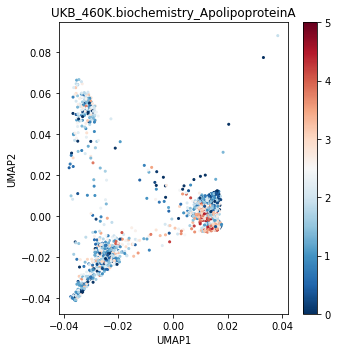

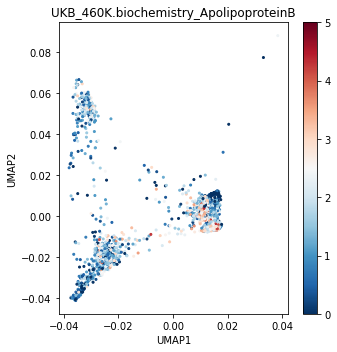

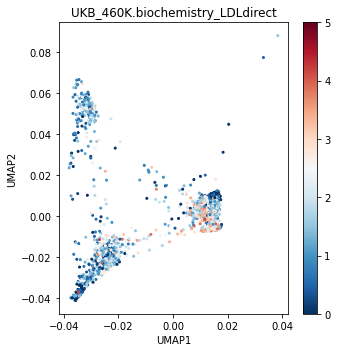

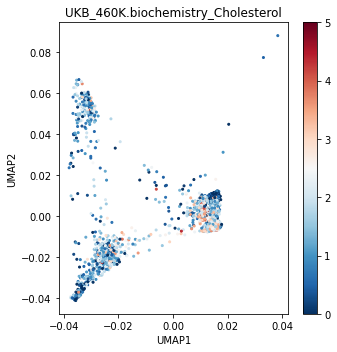

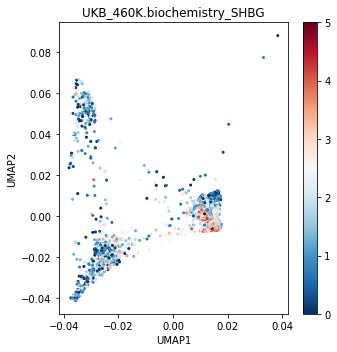

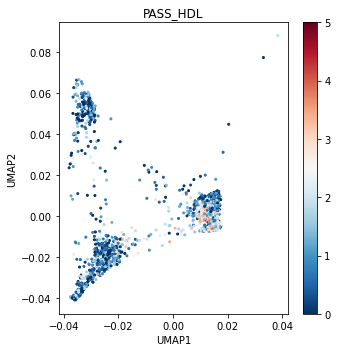

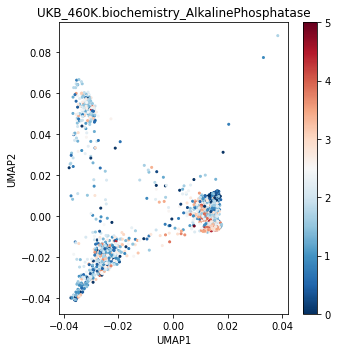

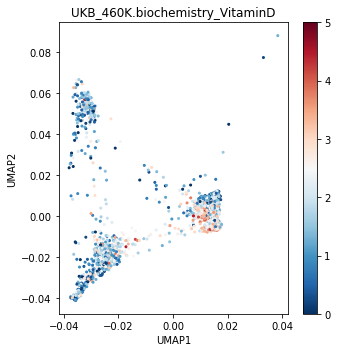

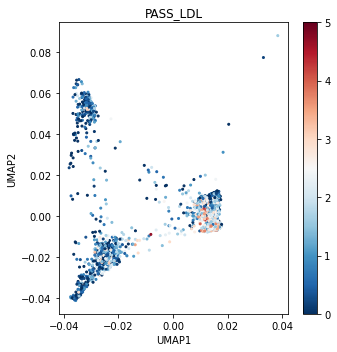

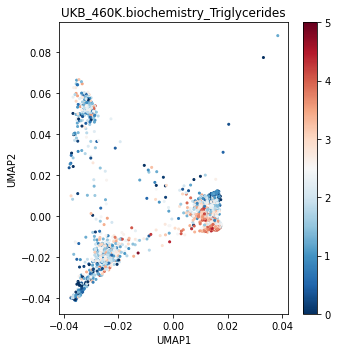

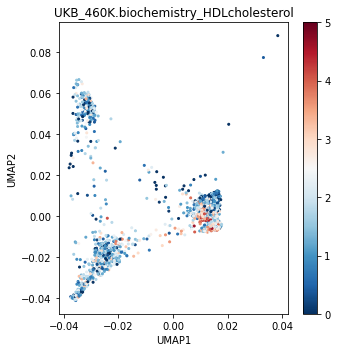

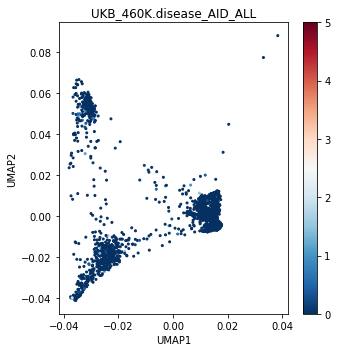

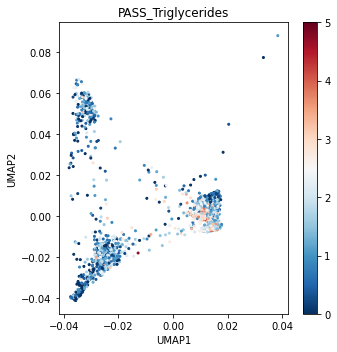

In [22]:
cell_list = list(adata.obs.index)
for trait in trait_plot_list:
    df_plot = pd.DataFrame(index=cell_list,
                           data={'DC1':adata.obsm['X_diffmap'][:,1],
                                 'DC2':adata.obsm['X_diffmap'][:,3],
                                 'zsc':df_score.loc[cell_list, '%s.zscore'%trait].values})
    
    plt.figure(figsize=[5,5])
    max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
    min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
    plt.scatter(df_plot['DC1'], df_plot['DC2'], c=df_plot['zsc'],
                cmap='RdBu_r', vmax=5, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%trait)
    plt.tight_layout()
    plt.show()

In [31]:
df_cell=pd.DataFrame(index=cell_list,
                     data={x: df_score.loc[cell_list, '%s.fdr'%x].values<0.05
                           for x in trait_plot_list})

... storing 'UKB_460K.blood_LYMPHOCYTE_COUNT' as categorical
... storing 'UKB_460K.biochemistry_TotalBilirubin' as categorical
... storing 'UKB_460K.biochemistry_DirectBilirubin' as categorical
... storing 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP' as categorical
... storing 'UKB_460K.biochemistry_AlanineAminotransferase' as categorical
... storing 'UKB_460K.biochemistry_Testosterone_Male' as categorical
... storing 'UKB_460K.disease_HI_CHOL_SELF_REP' as categorical
... storing 'PASS_Multiple_sclerosis' as categorical
... storing 'UKB_460K.disease_THYROID_ANY_SELF_REP' as categorical
... storing 'UKB_460K.biochemistry_ApolipoproteinA' as categorical
... storing 'UKB_460K.biochemistry_ApolipoproteinB' as categorical
... storing 'UKB_460K.biochemistry_LDLdirect' as categorical
... storing 'UKB_460K.biochemistry_Cholesterol' as categorical
... storing 'UKB_460K.biochemistry_SHBG' as categorical
... storing 'PASS_HDL' as categorical
... storing 'UKB_460K.biochemistry_AlkalinePhosphatase' a

         Falling back to preprocessing with `sc.pp.pca` and default params.


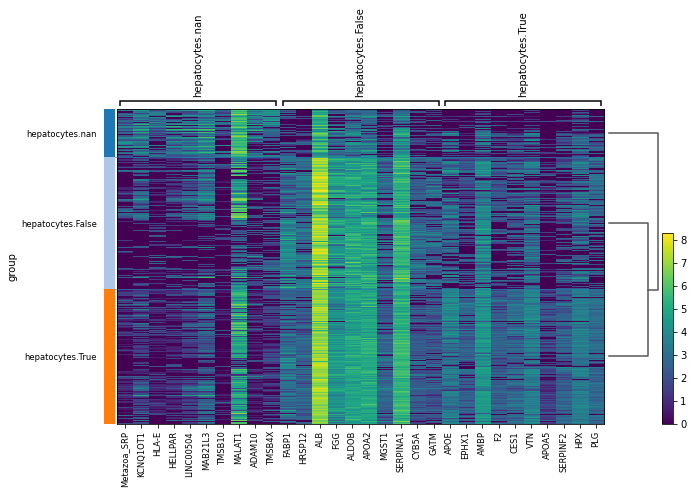

In [32]:
trait='UKB_460K.biochemistry_Triglycerides'

adata_small=dic_data_raw['aizarani'][(dic_data_raw['aizarani'].obs["celltype"]=='hepatocytes')].copy()
adata_small.obs = adata_small.obs.join(df_cell)

adata_small.obs['group'] = ['%s.%s'%(x,y) if x=='hepatocytes' else 'other'
                            for x,y in zip(adata_small.obs['celltype'], adata_small.obs[trait])]
adata_small.obs['group'] = adata_small.obs['group'].astype('category')
sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var')
sc.pl.rank_genes_groups_heatmap(adata_small)

In [35]:
from gprofiler import GProfiler
dic_pathway = {}
for term in adata_small.obs['group'].cat.categories:
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism='hsapiens', 
                            query=list(adata_small.uns['rank_genes_groups']['names'][term]),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw['aizarani'].var_names))
    dic_pathway[term] = df_pathway.copy()
    print(term)

hepatocytes.False
hepatocytes.True
hepatocytes.nan


In [37]:
temp_df = dic_pathway['hepatocytes.True'].copy()
ind_select = (temp_df['term_size']<500) & (temp_df['term_size']>5) & (temp_df['intersection_size']>10)
temp_df.loc[ind_select]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,KEGG,KEGG:04610,Complement and coagulation cascades,4.445221e-29,True,Complement and coagulation cascades,83,100,21,20848,0.21,0.253012,query_1,[KEGG:00000]
1,REAC,REAC:R-HSA-381426,Regulation of Insulin-like Growth Factor (IGF)...,1.062106e-27,True,Regulation of Insulin-like Growth Factor (IGF)...,109,100,22,20848,0.22,0.201835,query_1,[REAC:R-HSA-392499]
2,REAC,REAC:R-HSA-8957275,Post-translational protein phosphorylation,5.456621e-22,True,Post-translational protein phosphorylation,96,100,18,20848,0.18,0.187500,query_1,[REAC:R-HSA-597592]
4,REAC,REAC:R-HSA-114608,Platelet degranulation,2.318754e-20,True,Platelet degranulation,121,100,18,20848,0.18,0.148760,query_1,[REAC:R-HSA-76005]
5,REAC,REAC:R-HSA-76005,Response to elevated platelet cytosolic Ca2+,3.431739e-20,True,Response to elevated platelet cytosolic Ca2+,125,100,18,20848,0.18,0.144000,query_1,[REAC:R-HSA-76002]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,GO:BP,GO:0002283,neutrophil activation involved in immune response,9.551413e-05,True,"""The change in morphology and behavior of a ne...",445,100,11,20848,0.11,0.024719,query_1,"[GO:0002275, GO:0042119]"
367,GO:BP,GO:0042119,neutrophil activation,1.192082e-04,True,"""The change in morphology and behavior of a ne...",456,100,11,20848,0.11,0.024123,query_1,[GO:0036230]
372,GO:BP,GO:0036230,granulocyte activation,1.272059e-04,True,"""The change in morphology and behavior of a gr...",460,100,11,20848,0.11,0.023913,query_1,[GO:0002274]
390,GO:BP,GO:0043299,leukocyte degranulation,1.996865e-04,True,"""The regulated exocytosis of secretory granule...",485,100,11,20848,0.11,0.022680,query_1,"[GO:0002252, GO:0045055, GO:0051649]"


In [38]:
temp_df = dic_pathway['hepatocytes.False'].copy()
ind_select = (temp_df['term_size']<500) & (temp_df['term_size']>5) & (temp_df['intersection_size']>10)
temp_df.loc[ind_select]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
7,GO:BP,GO:0016054,organic acid catabolic process,6.014771e-19,True,"""The chemical reactions and pathways resulting...",271,96,22,20848,0.229167,0.081181,query_1,"[GO:0006082, GO:0044248, GO:0044282, GO:1901575]"
8,GO:BP,GO:0046395,carboxylic acid catabolic process,6.014771e-19,True,"""The chemical reactions and pathways resulting...",271,96,22,20848,0.229167,0.081181,query_1,"[GO:0016054, GO:0019752]"
9,GO:BP,GO:0044282,small molecule catabolic process,2.170964e-18,True,"""The chemical reactions and pathways resulting...",428,96,25,20848,0.260417,0.058411,query_1,"[GO:0009056, GO:0044281]"
11,GO:BP,GO:0098754,detoxification,6.053523e-14,True,"""Any process that reduces or removes the toxic...",116,96,14,20848,0.145833,0.120690,query_1,"[GO:0008150, GO:0009636]"
15,GO:BP,GO:0009636,response to toxic substance,1.389967e-11,True,"""Any process that results in a change in state...",215,96,15,20848,0.156250,0.069767,query_1,[GO:0042221]
17,GO:BP,GO:1901605,alpha-amino acid metabolic process,3.815202e-11,True,"""The chemical reactions and pathways involving...",189,96,14,20848,0.145833,0.074074,query_1,[GO:0006520]
18,GO:BP,GO:0006091,generation of precursor metabolites and energy,7.370010e-11,True,"""The chemical reactions and pathways resulting...",470,96,19,20848,0.197917,0.040426,query_1,[GO:0044237]
19,GO:BP,GO:0010038,response to metal ion,3.098225e-10,True,"""Any process that results in a change in state...",325,96,16,20848,0.166667,0.049231,query_1,[GO:0010035]
22,GO:BP,GO:0006066,alcohol metabolic process,9.037139e-10,True,"""The chemical reactions and pathways involving...",354,96,16,20848,0.166667,0.045198,query_1,"[GO:0044281, GO:1901615]"
26,GO:BP,GO:0009063,cellular amino acid catabolic process,1.099384e-09,True,"""The chemical reactions and pathways resulting...",121,96,11,20848,0.114583,0.090909,query_1,"[GO:0006520, GO:0046395, GO:1901565]"


In [39]:
temp_df = dic_pathway['hepatocytes.nan'].copy()
ind_select = (temp_df['term_size']<500) & (temp_df['term_size']>5) & (temp_df['intersection_size']>10)
temp_df.loc[ind_select]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
